<a href="https://www.kaggle.com/code/prakharbhartiya1/breast-cancer-detection?scriptVersionId=111910504" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm


import tensorflow as tf

In [2]:
base_path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [3]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

,patient_id,path,target
0,10295,../input/breast-histopathology-images/IDC_regu...,0
1,10295,../input/breast-histopathology-images/IDC_regu...,0
2,10295,../input/breast-histopathology-images/IDC_regu...,0
3,10295,../input/breast-histopathology-images/IDC_regu...,0
4,10295,../input/breast-histopathology-images/IDC_regu...,0


In [4]:
data.shape

(277524, 3)

In [5]:
data.target = data.target.astype(np.int)
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

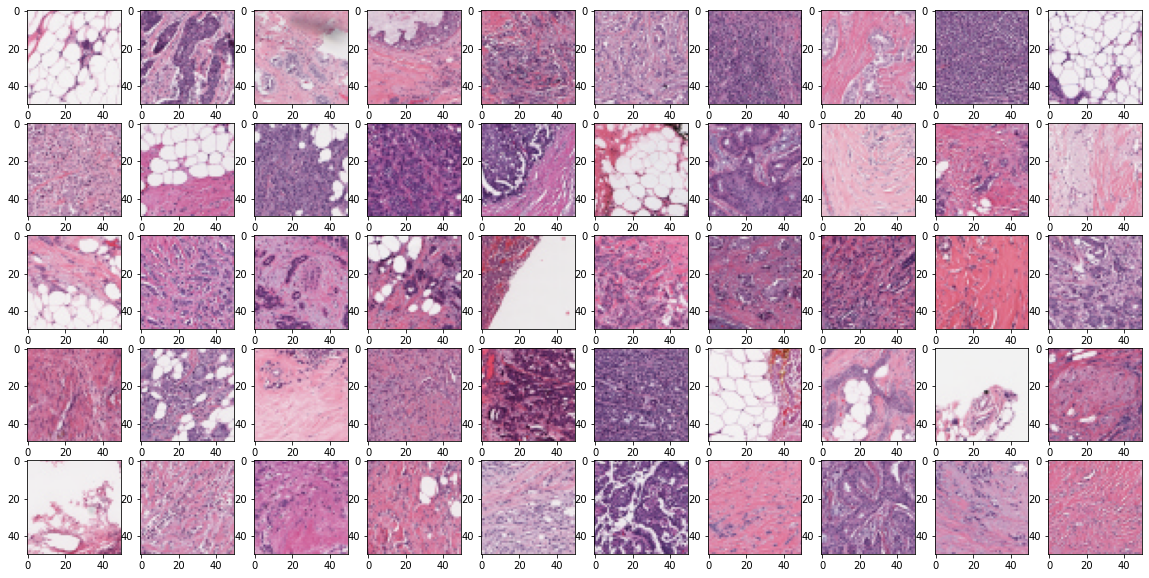

In [6]:
#Cancer Patches
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

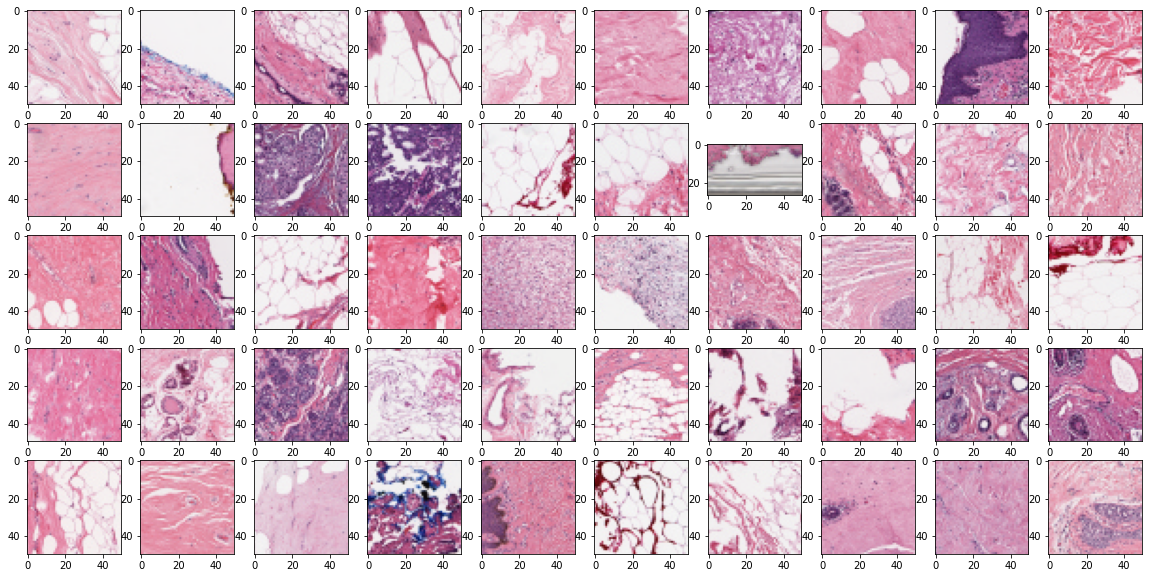

In [7]:
#Healthy Patches
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [8]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [9]:
def visualise_breast_tissue_base(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

In [10]:
def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches,_ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

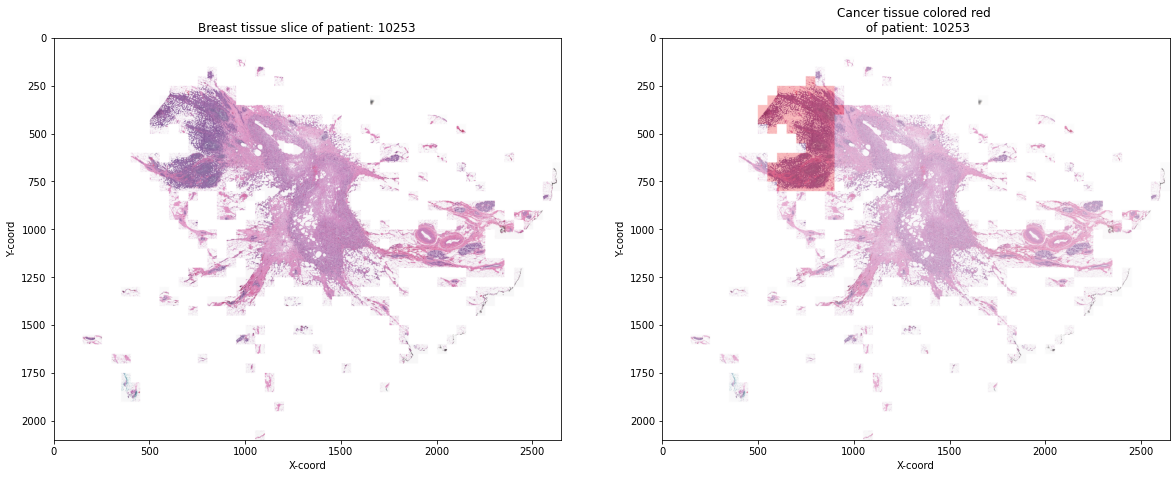

In [11]:
patient_id = "10253"
# get_patient_dataframe(patient_id)
visualise_breast_tissue(patient_id)

In [12]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1,1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")

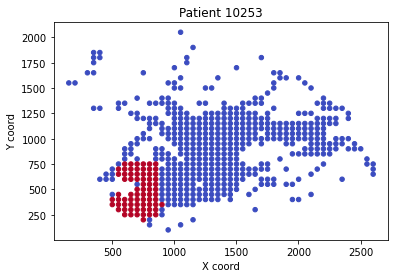

In [13]:
patient_id = "10253"
# get_patient_dataframe(patient_id)
visualise_breast_tissue_binary(patient_id)

In [14]:
#Data preprocessing

data.head()
data.loc[:, "target"] = data.target.astype(np.str)
data.info()

patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


In [15]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

In [16]:
from torch.utils.data import Dataset
class BreastCancerDataset(Dataset):
    
    def __init__(self, df):
        self.states = df
        
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        patient_id = self.states.patient_id.values[idx]
        x_coord = self.states.x.values[idx]
        y_coord = self.states.y.values[idx]
        image_path = self.states.path.values[idx] 
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if "target" in self.states.columns.values:
            target = np.int(self.states.target.values[idx])
        else:
            target = None
            
        return {"image": image,
                "label": target,
                "patient_id": patient_id,
                "x": x_coord,
                "y": y_coord}

In [17]:
train_dataset = BreastCancerDataset(train_df)
dev_dataset = BreastCancerDataset(dev_df)
test_dataset = BreastCancerDataset(test_df)

In [18]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

In [19]:
print("Training Dataset : ",dataset_sizes["train"])
print("Dev Dataset : ",dataset_sizes["dev"])
print("Test Dataset : ",dataset_sizes["test"])

Training Dataset :  196069
Dev Dataset :  40395
Test Dataset :  41060


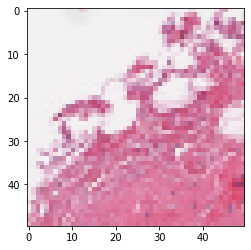

In [20]:
plt.imshow(image_datasets["test"].__getitem__(0)['image'])

In [21]:
#Creating database suitable for tensorflow
train_images = []
train_labels = []
# for i in range(dataset_sizes["train"]):
for i in range(1000):
    train_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    train_labels.append(image_datasets["train"].__getitem__(i)['label'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [22]:
train_images.shape

(1000, 50, 50, 3)

In [23]:
#Creating database suitable for tensorflow
test_images = []
test_labels = []
# for i in range(dataset_sizes["test"]):
for i in range(1000,2000):
    test_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    test_labels.append(image_datasets["train"].__getitem__(i)['label'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [24]:
test_images.shape

(1000, 50, 50, 3)

In [25]:
#Training
BATCH_SIZE = 32
NUM_CLASSES = 2

from tensorflow.keras import datasets, layers, models

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [26]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

2022-11-24 03:49:36.184011: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

2022-11-24 03:49:36.551081: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
32/32 [==============================] - 3s 57ms/step - loss: 0.3956 - accuracy: 0.8440 - val_loss: 0.3474 - val_accuracy: 0.8990
Epoch 2/10
32/32 [==============================] - 2s 79ms/step - loss: 0.2895 - accuracy: 0.8760 - val_loss: 0.2717 - val_accuracy: 0.8700
Epoch 3/10
32/32 [==============================] - 2s 49ms/step - loss: 0.2157 - accuracy: 0.9160 - val_loss: 0.3113 - val_accuracy: 0.8710
Epoch 4/10
32/32 [==============================] - 2s 49ms/step - loss: 0.1817 - accuracy: 0.9290 - val_loss: 0.3331 - val_accuracy: 0.8370
Epoch 5/10
32/32 [==============================] - 2s 50ms/step - loss: 0.1900 - accuracy: 0.9260 - val_loss: 0.3752 - val_accuracy: 0.8690
Epoch 6/10
32/32 [==============================] - 2s 49ms/step - loss: 0.2294 - accuracy: 0.9190 - val_loss: 0.3432 - val_accuracy: 0.8340
Epoch 7/10
32/32 [==============================] - 2s 49ms/step - loss: 0.1623 - accuracy: 0.9430 - val_loss: 0.3516 - val_accuracy: 0.8400
Epoch 8/10
32

32/32 - 0s - loss: 0.4455 - accuracy: 0.8820


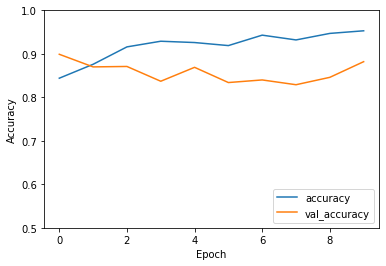

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [29]:
print(test_acc)

0.8820000290870667


In [30]:
#single image prediction
def predict_single_image(idx):
    img = []
    img.append(np.array(image_datasets["train"].__getitem__(idx)['image']))
    img = np.array(img)
    print("Cancer : 1","No Cancer : 0")
    print("True Lable : ",image_datasets["train"].__getitem__(idx)['label'])
    print("Predicted Label : ", model.predict(img).argmax(axis=-1)[0])

In [31]:
predict_single_image(25)

Cancer : 1 No Cancer : 0
True Lable :  0
Predicted Label :  0
